
## What does _makeitpop_ do?

Makeitpop lets you apply the same perceptual warping that would _normally_ be accomplished
with a colormap like Jet, but applies this warping to _the data itself_! This lets us
visualize it with a nice linear colormap like `viridis`!

This notebooks demonstrates how this works. Note that `makeitpop` was mostly designed
as a proof-of-concept for [this blog post on the perceptual warping of colormaps](https://predictablynoisy.com/makeitpop-intro). See below for a few demonstrations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from makeitpop import makeitpop, update_derivatives, cmaps
import seaborn as sns
sns.set(font_scale=2, style='white')

# Get the perceptual derivatives we use for popping so we can visualize
derivatives, derivatives_scaled = update_derivatives(cmaps)

For example, let's take a look at the [image demo in matplotlib](https://matplotlib.org/gallery/images_contours_and_fields/image_demo.html#sphx-glr-gallery-images-contours-and-fields-image-demo-py). In it, we create two blobs that are meant to be visualized as an image. Let's visualize this with our old friend viridis.

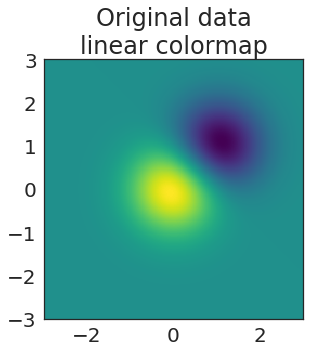

In [2]:
# Create our data
delta = 0.025
x = y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nlinear colormap")
plt.tight_layout()

Hmmm, not too bad...but it's a bit _boring_, no? Why can't we make it snazzier? I know, let's use Jet!

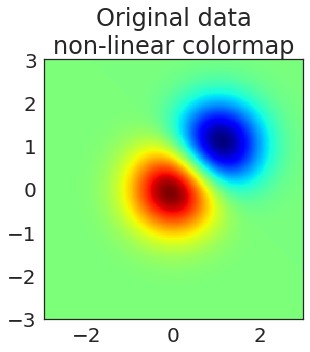

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z, cmap=plt.cm.jet,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Original data\nnon-linear colormap")
plt.tight_layout()

Oooh now that's what I'm talking about. You can clearly see two peaks of significant results
at the center of each circle. Truly this is fit for publishing in _Nature_.

But...as you all know, this data only _looks_ better because we've used a colormap that distorts
our perception of the underlying data.

Let's illustrate this by **making it pop**!

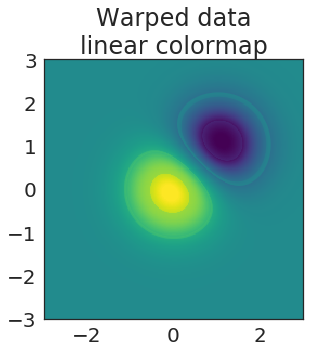

In [4]:
Z_popped = makeitpop(Z, 'jet', scaling_factor=20)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(Z_popped, cmap=plt.cm.viridis,
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
ax.set(title="Warped data\nlinear colormap")
plt.tight_layout()

## Perceptual "delta" curves

You can determine the extent to which a colormap "warps" your perception of the data by calculating the "perceptual deltas" as you move across the values of a colormap (e.g. as you move from 0 to 1, and their corresponding colors).

These deltas essentially mean "how much is the _next_ color in the colormap perceived as different from the _current_ color?" If your colormap is perceptually flat, the delta will be the *same* no matter where you are on the range from 0 to 1.

Let's see what this delta looks like for Jet:

[Text(0.5, 1.0, 'Perceptual deltas with Jet')]

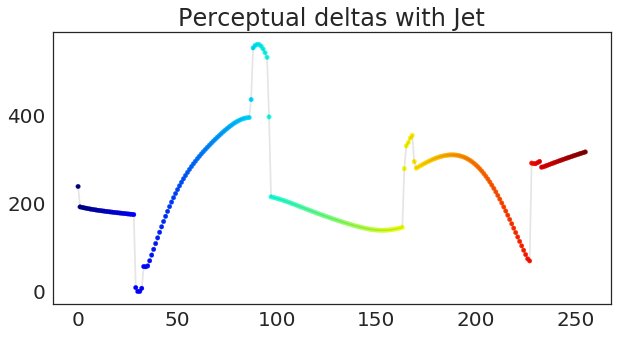

In [5]:
def plot_colormap_deltas(deltas, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    xrange = np.arange(len(derivatives))
    sc = ax.scatter(xrange, deltas, c=xrange, vmin=xrange.min(), vmax=xrange.max(),
                    cmap=plt.cm.get_cmap(cmap), s=20)
    ax.plot(xrange, deltas, c='k', alpha=.1)
    return ax

ax = plot_colormap_deltas(derivatives['jet'].values, 'jet')
ylim = ax.get_ylim()  # So we can compare with other colormaps
ax.set(title="Perceptual deltas with Jet")

Oops.

As you can see, Jet does **not** have a flat line for perceptual deltas. Each "jump" you see above is a moment where Jet is actually _mis-representing_ differences in the data. For shame, Jet.

Now let's see what this looks like for viridis:

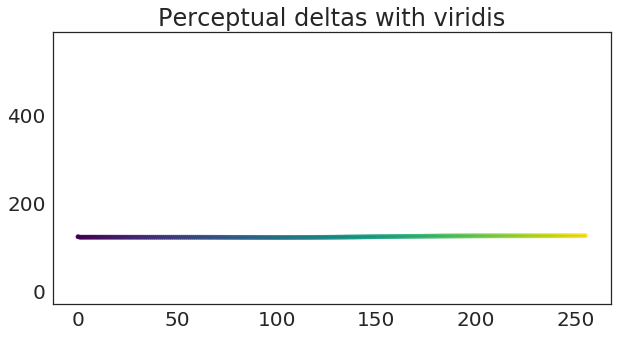

In [6]:
ax = plot_colormap_deltas(derivatives['viridis'].values, 'viridis')
ax.set(ylim=ylim, title="Perceptual deltas with viridis");

## Warping 1-dimensional data!

Let's see how this principle affects our perception with a different kind of visual
encoding. Now that we know these perceptual warping functions, we can get all the
data-warping properties of jet, but in one dimension!

Here's a line.

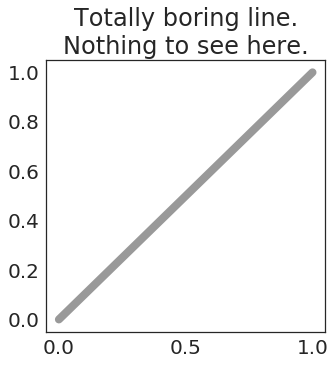

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k-', lw=8, alpha=.4, label='True Data')
ax.set_title('Totally boring line.\nNothing to see here.');

Ew. Boring.

Now, let's make it pop! We'll loop through a few colormaps, applying its color
warping function to the y-axis of our line as we step through it.

Text(0.5, 1.0, 'Making data "pop" is fun!')

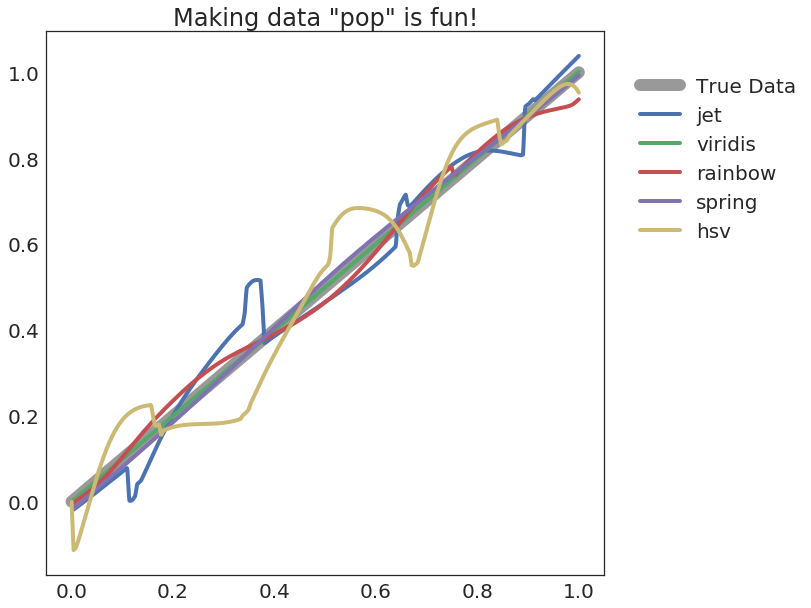

In [8]:
names = ['jet', 'viridis', 'rainbow', 'spring', 'hsv']
fig, ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 1, 1000)
ax.plot(x, x, 'k-', lw=12, alpha=.4, label='True Data')
for nm in names:
    ax.plot(x, makeitpop(x, colormap=nm, scaling_factor=40), label=nm, lw=4)
    ax.legend(loc=(1.05, .6))
ax.set_title('Making data "pop" is fun!')

As you can see, data looks much more interesting when it's been non-linearly warped!
It looks particularly striking when you see it on a 1-D plot. This is effectively
what colormaps such as Jet are doing in 2 dimensions! We're simply bringing the fun
back to 1-D space.

Let's see how it looks on some scatterplots. We'll plot the raw data in the background in grey,
and the "popped" data in front in color. Notice how some colormaps distort the y-values more
than others.

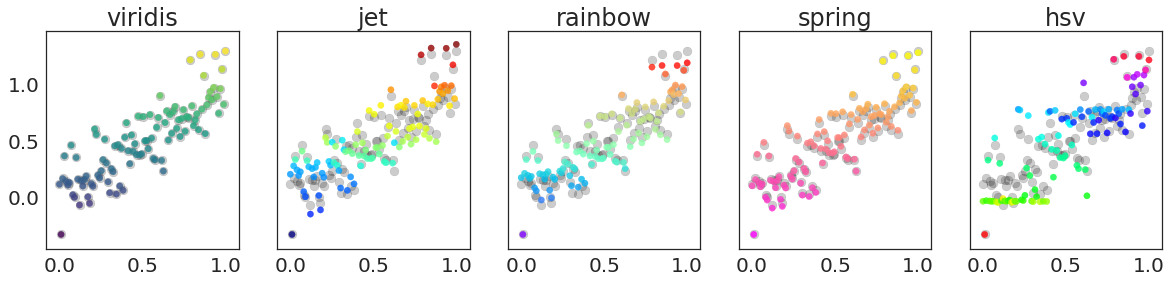

In [9]:
names = ['viridis', 'jet', 'rainbow', 'spring', 'hsv']
fig, axs = plt.subplots(1, len(names), figsize=(20, 4), sharex=True, sharey=True)
x = np.linspace(0, 1, 100)
y = x + np.random.randn(len(x)) * .2
for name, ax in zip(names, axs):    
    ax.scatter(x, y, c='k', s=80, alpha=.2)
    ax.scatter(x, makeitpop(y, name, 40), c=y, s=40, alpha=.8, cmap=plt.get_cmap(name))
    ax.set(title=name)


# Some extras

Here's a little interactive widget to visualize how the scaling factor affects the "pop" effect.

Note that this depends on the image from the first section of this tutorial to be created.

In [11]:
from ipywidgets import interact, IntSlider, Dropdown

In [12]:
def viz(scaling_factor, cmap):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    Z_popped = makeitpop(Z, cmap, scaling_factor=scaling_factor)

    axs[0].imshow(Z, cmap=plt.get_cmap(cmap),
          origin='lower', extent=[-3, 3, -3, 3],
          vmax=abs(Z).max(), vmin=-abs(Z).max())
    axs[1].imshow(Z_popped, cmap=plt.cm.viridis,
              origin='lower', extent=[-3, 3, -3, 3],
              vmax=abs(Z).max(), vmin=-abs(Z).max())
    ax.set(title="Warped data\nlinear colormap")
    plt.show()
interact(viz, scaling_factor=IntSlider(1, 1, 80),
         cmap=Dropdown(options=derivatives_scaled.columns.values, value='jet'))

interactive(children=(IntSlider(value=1, description='scaling_factor', max=80, min=1), Dropdown(description='c…

<function __main__.viz(scaling_factor, cmap)>